In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

from modules import Net, AWNGChannel, BSChannel, RepeatEncoder, RepeatDecoder

In [2]:
R = 5
n_batches = 100
batch_size = 128
n_bits = 64
code_len = R*n_bits

In [3]:
class ConvEncoder(nn.Module):
    def __init__(self, R, c):
        super(ConvEncoder, self).__init__()
        self.conv0 = nn.Conv1d(1, c, kernel_size=R, padding=R//2)
        self.bn0 = nn.BatchNorm1d(c)
        self.conv1 = nn.ConvTranspose1d(c, c, kernel_size=R, stride=R)
        self.bn1 = nn.BatchNorm1d(c)
        self.conv2 = nn.Conv1d(c, c, kernel_size=R, padding=R//2)
        self.bn2 = nn.BatchNorm1d(c)
        self.conv3 = nn.Conv1d(c, 1, kernel_size=R, padding=R//2)
        #self.conv4 = nn.Conv1d(c, 1, kernel_size=R, padding=R//2)
    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x.unsqueeze(1))))
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.sigmoid(self.conv3(x))
        return 2*x - 1

class ConvDecoder(nn.Module):
    def __init__(self, R, c):
        super(ConvDecoder, self).__init__()
        self.conv1 = nn.Conv1d(1, c, kernel_size=R, padding=R//2)
        #self.conv2 = nn.Conv1d(c, c, kernel_size=R, padding=R//2)
        self.conv3 = nn.Conv1d(c, 1, kernel_size=R, stride=R)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        x = self.conv3(x).squeeze()
        return x

n_channels = 32
encoder = ConvEncoder(R, n_channels).cuda()
decoder = ConvDecoder(R, n_channels).cuda()
channel = AWNGChannel(1.0).cuda()
params = [p for p in encoder.parameters()] + [p for p in decoder.parameters()]

0.986966552734


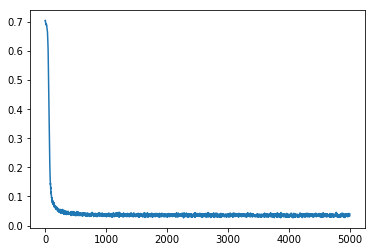

In [4]:
n_stops = 0
n_stale_epochs = 0
n_epochs = 0
optimizer = optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0)
losses = []

for i in range(50):

    all_data = (torch.rand((n_batches, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
    n_correct = 0

    for data in all_data:
        optimizer.zero_grad()
        data = Variable(data.cuda())
        message = encoder(data)
        corrupted = channel(message)
        reconstruction = decoder(corrupted)
        loss = F.binary_cross_entropy_with_logits(reconstruction, data)
        loss.backward()
        optimizer.step()

        n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
        losses.append(loss.data[0])
        
    n_epochs += 1
        
    #if n_epochs == 2:
    #    optimizer.param_groups[0]['lr'] *= 0.1
    
plt.plot(losses)

print float(n_correct) / all_data.nelement()

(0.02, 0.05)

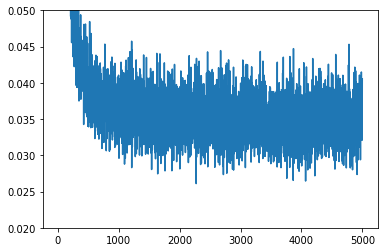

In [5]:
plt.plot(losses)
plt.ylim([0.02, 0.05])

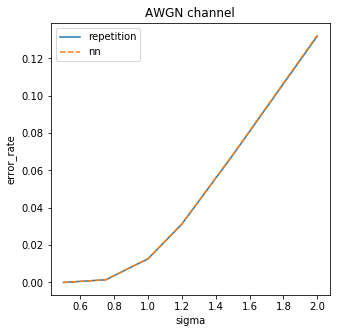

In [6]:
def model_accuracy(encoder, decoder, channel):
    all_data = (torch.rand((1000, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
    n_correct = 0
    for data in all_data:
        data = Variable(data.cuda(), volatile=True)
        message = encoder(data)
        corrupted = channel(message)
        reconstruction = decoder(corrupted) 
        n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
    return float(n_correct) / all_data.nelement()

sigmas = np.array([0.5, 0.75, 1.0, 1.2, 1.5, 2.0])
nn_err = np.array([1-model_accuracy(encoder, decoder, AWNGChannel(s)) for s in sigmas])
baseline_encoder = RepeatEncoder(R)
baseline_decoder = RepeatDecoder(R)
repeater_err = np.array([1-model_accuracy(baseline_encoder, baseline_decoder, AWNGChannel(s)) for s in sigmas])
plt.figure(figsize=(5, 5))
plt.title('AWGN channel')
plt.plot(sigmas, repeater_err, '-', label='repetition')
plt.plot(sigmas, nn_err, '--', label='nn')
plt.legend()
plt.ylabel('error_rate')
plt.xlabel('sigma')
plt.savefig('awgn_conv.png', dpi=120)

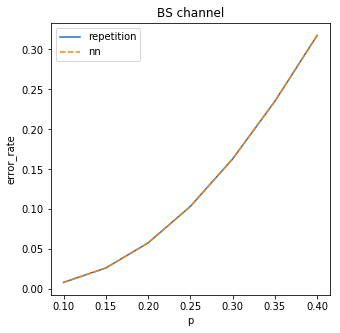

In [7]:
sigmas = np.linspace(0.1, 0.4, 7)
nn_err = np.array([1-model_accuracy(encoder, decoder, BSChannel(s)) for s in sigmas])
repeater_err = np.array([1-model_accuracy(baseline_encoder, baseline_decoder, BSChannel(s)) for s in sigmas])
plt.figure(figsize=(5, 5))
plt.title('BS channel')
plt.plot(sigmas, repeater_err, '-', label='repetition')
plt.plot(sigmas, nn_err, '--', label='nn')
plt.legend()
plt.ylabel('error_rate')
plt.xlabel('p')
plt.savefig('bsc_conv.png', dpi=120)